In [3]:
  # pip install packages  
  !pip install category_encoders==2.*
  !pip install eli5
  !pip install pdpbox
  !pip install shap

     |████████████████████████████████| 102kB 2.4MB/s 
     |████████████████████████████████| 112kB 2.8MB/s 
     |████████████████████████████████| 57.7MB 39kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690723 sha256=af2825485c7c08abfc9df1ecf1dbcf0ef2ad007f23009db1f1a4039bcd0f7a77
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox
     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.32.1-cp36-cp36m-linux_x86_64.whl size=376813 sha256=609f80d1bda9036a4b90f3de3ca8b7dfbc99dc4a898a544db30c81624f04daf9
  Stored in directory: /root/.cache/pip/wheels/8e/b2/50/8fadb5a59789cb5bdeb01b800223be540651ae92915172050b
Successfully built shap


In [0]:
import pandas as pd
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score

#cleaning the data

In [0]:
#import dataframe from sorce
sumo_matches = pd.read_csv('https://query.data.world/s/kp5eazhvwdbrnhhyow5lm4kfywhyvg') # fight result dataframe
sumo_info = pd.read_csv('https://query.data.world/s/6gckbhyl6klbem3vs25chgcaw65gfa') # sumo info dataframe

In [0]:
# remove all nan values from sumo info
sumo_info = sumo_info.dropna()

In [0]:
# remove rank, name ..etc. this datafram will be used to merge with sumo matches data framw
sumo_info_2 = sumo_info.drop(['rank','rikishi','prev','prev_w','prev_l'],axis=1)

In [0]:
# create copies for sumo1 and 2
sumo_1 = sumo_info_2.copy()
sumo_2 = sumo_info_2.copy()

In [0]:

sumo_1 = sumo_1.rename(columns={"id":"rikishi1_id","weight": "rikishi1_weight","height":"rikishi1_height","heya": "rikishi1_heya","shusshin":"rikishi1_shusshin","birth_date": "rikishi1_birthday"})

In [0]:
sumo_2 = sumo_2.rename(columns={"id":"rikishi2_id","weight": "rikishi2_weight","height":"rikishi2_height","heya": "rikishi2_heya","shusshin":"rikishi2_shusshin","birth_date": "rikishi2_birthday"})

In [0]:
# removing duplicates from dataset
sumo_matches_1 = sumo_matches.loc[(sumo_matches.index%2)==0]

In [12]:
# dumb model
sumo_matches_1.rikishi1_win.value_counts(normalize=True)

1    0.51785
0    0.48215
Name: rikishi1_win, dtype: float64

In [0]:
#merge datasets now
sumo_matches_rik1 = pd.merge(sumo_matches_1,sumo_1,how='left',on=['basho','rikishi1_id'])

In [0]:
sumo_matches_rik1_rik2 = pd.merge(sumo_matches_rik1,sumo_2,how='left',on=['basho','rikishi2_id'])

In [0]:
df = sumo_matches_rik1_rik2

In [17]:
df

,basho,day,rikishi1_id,rikishi1_rank,rikishi1_shikona,rikishi1_result,rikishi1_win,kimarite,rikishi2_id,rikishi2_rank,rikishi2_shikona,rikishi2_result,rikishi2_win,rikishi1_heya,rikishi1_shusshin,rikishi1_birthday,rikishi1_height,rikishi1_weight,rikishi2_heya,rikishi2_shusshin,rikishi2_birthday,rikishi2_height,rikishi2_weight
0,1983.01,1,4140,J13w,Chikubayama,0-1 (7-8),0,yorikiri,4306,Ms1e,Ofuji,1-0 (6-1),1,Miyagino,Fukuoka,1957-08-21,175.5,115.0,Kokonoe,Tokyo,1958-08-26,193.5,145.0
1,1983.01,1,1337,J12w,Tochitsukasa,1-0 (9-6),1,oshidashi,4323,J13e,Shiraiwa,0-1 (3-12),0,Kasugano,Aichi,1958-04-25,178.5,130.0,Isegahama,Akita,1957-03-05,182.4,103.0
2,1983.01,1,4097,J12e,Tamakiyama,0-1 (8-7),0,yorikiri,4319,J11w,Harunafuji,1-0 (5-10),1,Kataonami,Fukuoka,1951-04-29,182.0,134.0,Taiho,Gunma,1959-02-03,178.3,156.0
3,1983.01,1,4109,J10w,Kotogatake,0-1 (7-8),0,tsukidashi,4129,J11e,Hakuryuyama,1-0 (3-12),1,Sadogatake,Hokkaido,1952-09-24,186.0,110.0,Tokitsukaze,Hyogo,1954-07-10,178.5,113.0
4,1983.01,1,4111,J10e,Zaonishiki,0-1 (4-11),0,hatakikomi,4130,J9w,Hachiya,1-0 (8-7),1,Kagamiyama,Yamagata,1952-09-03,183.0,134.0,Kasugano,Gifu,1950-11-16,179.0,106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107389,2019.09,15,11784,M6w,Myogiryu,8-5-2,1,yorikiri,12094,K1e,Abi,9-6,0,Sakaigawa,Hyogo,1986-10-22,187.0,148.0,Shikoroyama,Saitama,1994-05-04,185.0,121.0
107390,2019.09,15,6463,M8e,Okinoumi,11-4,0,oshidashi,12191,S1w,Takakeisho,12-3,1,Hakkaku,Shimane,1985-07-29,190.0,154.0,Chiganoura,Hyogo,1996-08-05,173.0,149.0
107391,2019.09,15,12055,K1w,Endo,8-7,0,yorikiri,12210,S1e,Mitakeumi,12-3,1,Oitekaze,Ishikawa,1990-10-19,183.0,145.6,Dewanoumi,Nagano,1992-12-25,179.0,149.0
107392,2019.09,15,6468,O1w,Goeido,10-5,1,yorikiri,6599,O2e,Tochinoshin,6-9,0,Sakaigawa,Osaka,1986-04-06,183.0,158.2,Kasugano,Georgia,1987-10-13,192.0,162.0


In [18]:
df.isnull().sum()

basho                 0
day                   0
rikishi1_id           0
rikishi1_rank         0
rikishi1_shikona      0
rikishi1_result       0
rikishi1_win          0
kimarite              0
rikishi2_id           0
rikishi2_rank         0
rikishi2_shikona      0
rikishi2_result       0
rikishi2_win          0
rikishi1_heya         0
rikishi1_shusshin     0
rikishi1_birthday     0
rikishi1_height       0
rikishi1_weight       0
rikishi2_heya        31
rikishi2_shusshin    31
rikishi2_birthday    31
rikishi2_height      31
rikishi2_weight      31
dtype: int64

In [0]:
#remove all rows that didnt have weight or a height attached to them
df = df.dropna()

#Dum model

In [0]:
# creating a dum model first 
target = 'rikishi1_win'
features = df.drop(columns=['rikishi1_win','rikishi2_win'])
features = features.columns

In [0]:
train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df['rikishi1_win'], random_state=42)

In [0]:
train, validate = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['rikishi1_win'], random_state=42)

In [0]:
x_train = train[features]
y_train = train[target]
x_validate = validate[features]
y_validate = validate[target]
x_test = test[features]
y_test = test[target]

In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    #RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    StandardScaler(),
    LogisticRegression()
)

In [19]:
pipeline.fit(x_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['rikishi1_rank', 'rikishi1_shikona',
                                      'rikishi1_result', 'kimarite',
                                      'rikishi2_rank', 'rikishi2_shikona',
                                      'rikishi2_result', 'rikishi1_heya',
                                      'rikishi1_shusshin', 'rikishi1_birthday',
                                      'rikishi2_heya', 'rikishi2_shusshin',
                                      'rikishi2_birthday'],
                                drop_invariant=False, handle_missing='value',
                                handle_un...
                                return_df=True, verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                          

In [20]:
# the dum model was able to gets 52% accuracy with logestic regression model
pipeline.score(x_test,y_test)

0.5289433241745448

In [0]:
###
# This block is not in use
##
# the graph is showing that rikishi 1 and 2 result were the most important factors in the model. the results feature shows the points for the match which
# would definitely cause leakage 
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(x_test).columns
importance = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importance.sort_values().plot.barh(color='grey');

KeyError: ignored

# Feature selection

In [0]:
# creating new model to get better accuracy 
new_df = df.drop(['rikishi1_id', 'rikishi1_rank','rikishi1_shikona','rikishi1_result','kimarite','rikishi2_id', 'rikishi2_rank','rikishi2_shikona','rikishi2_result','kimarite',],axis=1)

In [0]:
new_df_1=new_df.copy()

In [0]:
# this code block formats basho, day and the sumos birthdays

new_df_1.basho = new_df_1.basho.apply(lambda x: (str(x).replace(".","-")))
new_df_1.day = new_df_1.day.astype(str)
new_df_1.basho = new_df_1.basho + "-"+new_df_1.day

# turns columns to datetime
new_df_1.rikishi1_birthday = pd.to_datetime(new_df_1.rikishi1_birthday)
new_df_1.rikishi2_birthday =  pd.to_datetime(new_df_1.rikishi2_birthday)
new_df_1.basho = pd.to_datetime(new_df_1.basho)

# creates new column called for sumo age
new_df_1['rikishi1_age'] = (new_df_1.basho-new_df_1.rikishi1_birthday)
new_df_1['rikishi2_age'] = (new_df_1.basho-new_df_1.rikishi2_birthday)
new_df_1['rikishi1_age'] = new_df_1.rikishi1_age.apply(lambda x: round(x.days/365,1))
new_df_1['rikishi2_age'] = new_df_1.rikishi2_age.apply(lambda x: round(x.days/365,1))

In [0]:
new_df_1.basho = new_df.basho
new_df_1.day = new_df.day

In [0]:
new_df_1['older'] = new_df_1.rikishi1_age > new_df_1.rikishi2_age
new_df_1['taller'] = new_df_1.rikishi1_height > new_df_1.rikishi2_height
new_df_1['heavier'] = new_df_1.rikishi1_weight > new_df_1.rikishi2_weight

In [0]:
new_df_1 = new_df_1.drop(['basho','day'],axis=1)

In [0]:
pipeline2 = make_pipeline(
    ce.OrdinalEncoder(), 
    StandardScaler(),
   RandomForestClassifier(max_depth=2,n_estimators=100, random_state=42, n_jobs=-1)
   # XGBClassifier(n_estimators=20, n_jobs=-1)
    #XGBClassifier(max_depth=4, n_estimators=1000, n_jobs=-1, 
                        #random_state=42)
)

In [0]:
train1, test1 = train_test_split(new_df_1, train_size=0.80, test_size=0.20, 
                              stratify=new_df_1['rikishi1_win'], random_state=42)

features1 = new_df_1.drop(columns=['rikishi1_win','rikishi2_win','rikishi1_birthday','rikishi2_birthday'])
features1 = features1.columns

In [0]:
pipeline2.named_steps


{'ordinalencoder': OrdinalEncoder(cols=None, drop_invariant=False, handle_missing='value',
                handle_unknown='value', mapping=None, return_df=True, verbose=0),
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'xgbclassifier': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=4,
               min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
               nthread=None, objective='binary:logistic', random_state=42,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1)}

In [2]:
new_df_1

NameError: ignored

In [0]:
new_df_1.	rikishi1_heya.value_counts()

Sadogatake     6893
Futagoyama     5917
Kasugano       5829
Dewanoumi      4364
Kokonoe        4182
               ... 
Kiriyama         45
Shikihide        20
Nishikido        16
Hatachiyama       9
Asakayama         7
Name: rikishi1_heya, Length: 63, dtype: int64

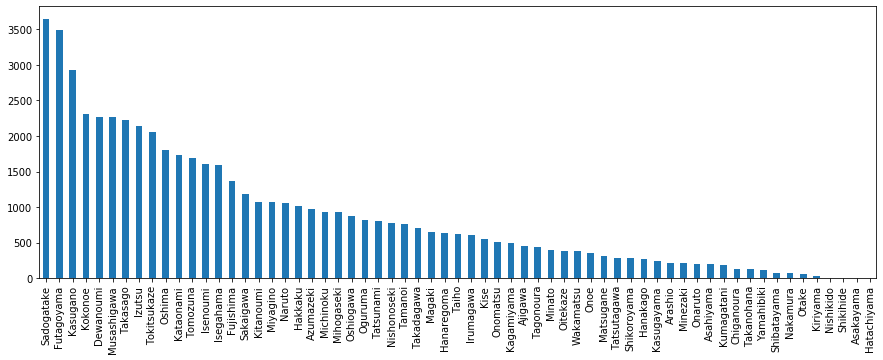

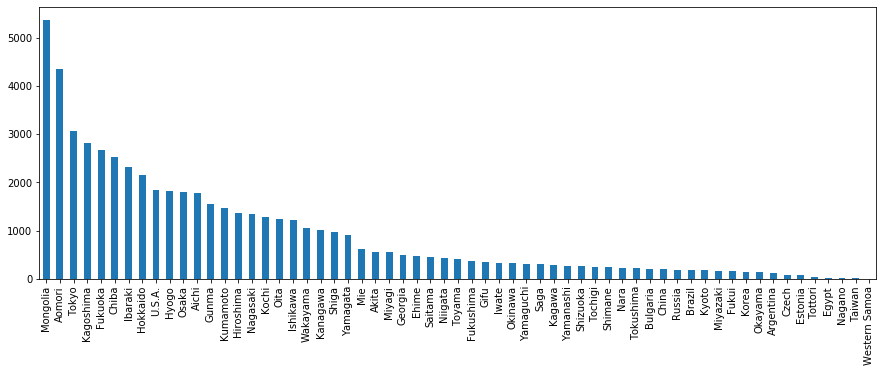

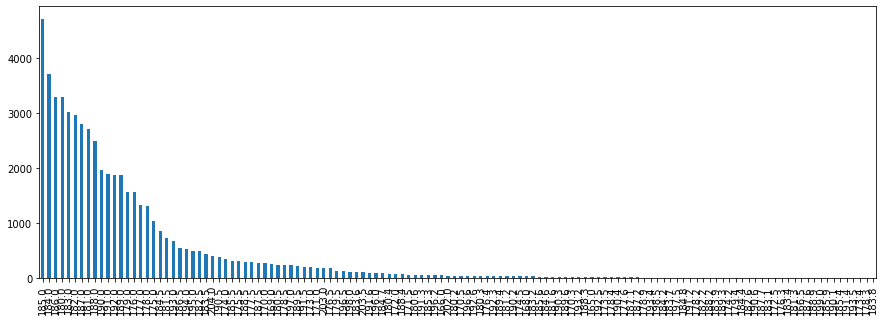

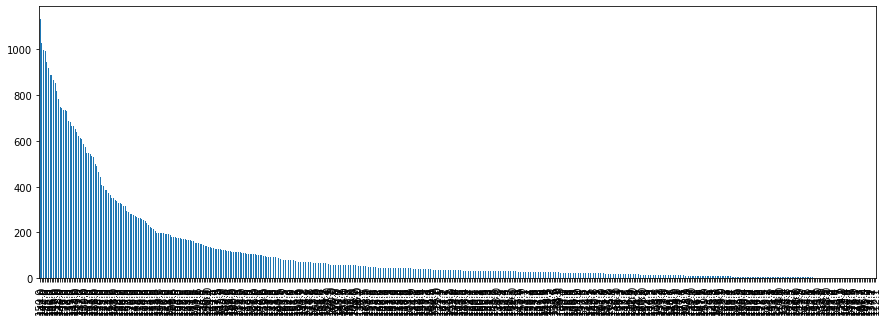

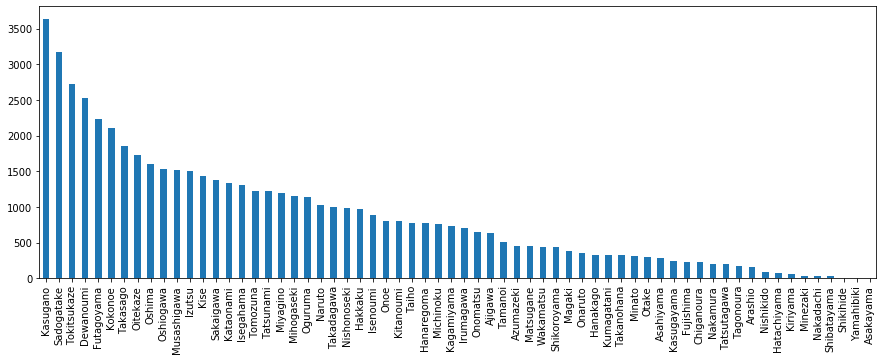

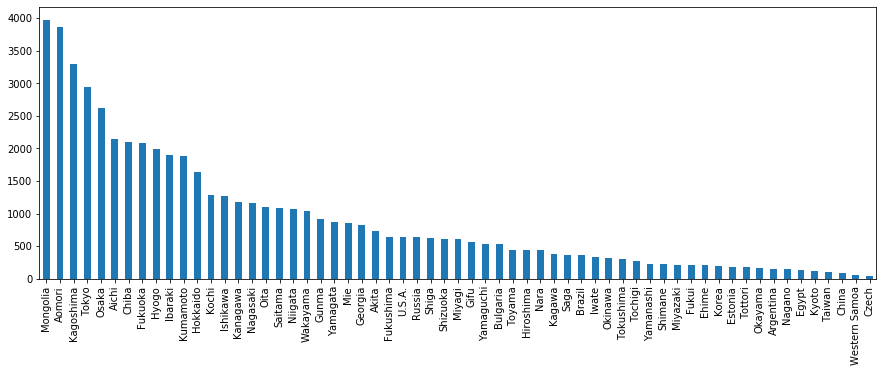

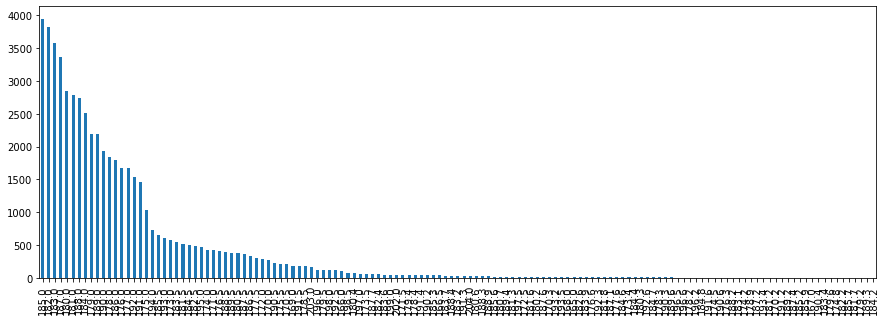

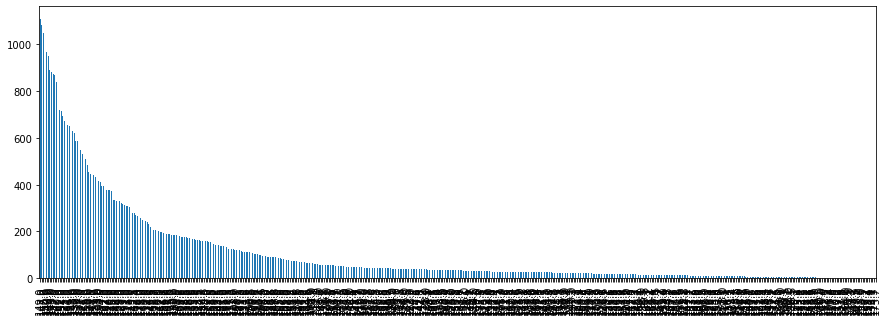

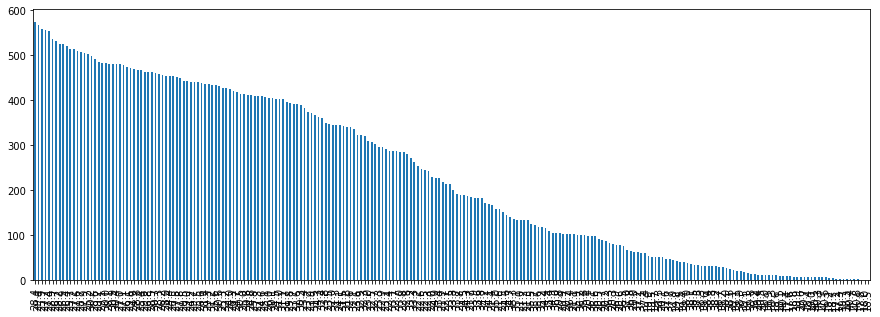

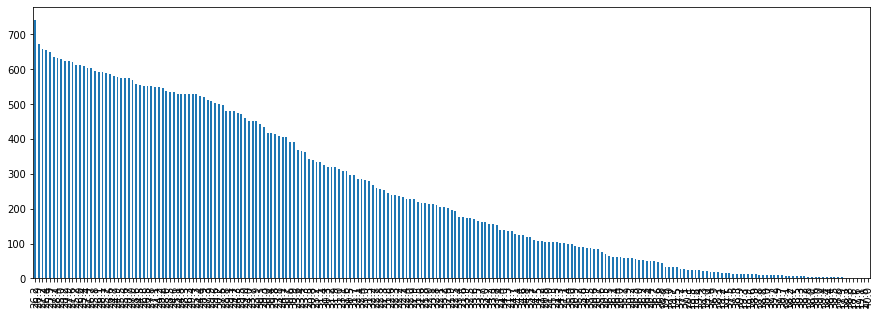

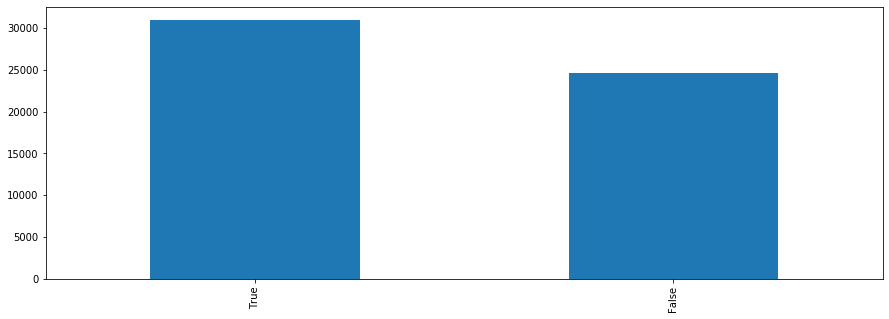

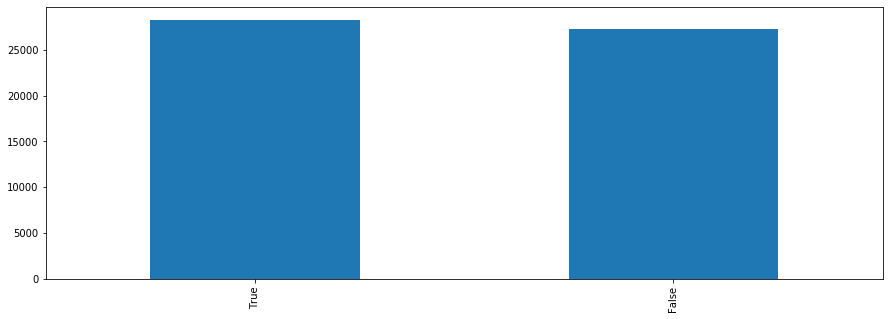

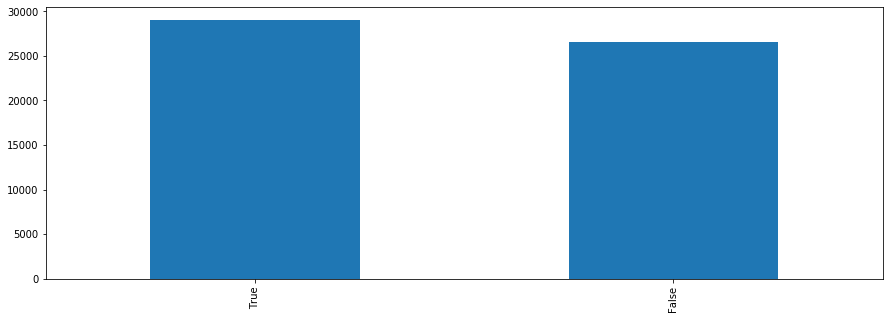

In [0]:
feat = features1.drop(['basho','day'])
for i in range(len(feat)):
    new_df_1[new_df_1.rikishi1_win==1][feat[i]].value_counts().plot(kind='bar',figsize=(15,5))#sort_values(ascending=False))#.plot(kind='bar'))
    plt.show()
#new_df_1[new_df_1.rikishi1_win==0]['heavier'].value_counts().sort_index().plot(kind='bar')
#plt.show()

In [0]:
x_train1 = train1[features1]
y_train1 = train1[target]
x_test1 = test1[features1]
y_test1 = test1[target]

In [50]:
#for i in 
pd.DataFrame(new_df_1.rikishi1_heya.value_counts()).index

Index(['Sadogatake', 'Futagoyama', 'Kasugano', 'Dewanoumi', 'Kokonoe',
       'Tokitsukaze', 'Takasago', 'Izutsu', 'Musashigawa', 'Kataonami',
       'Oshima', 'Isenoumi', 'Isegahama', 'Tomozuna', 'Fujishima', 'Sakaigawa',
       'Kitanoumi', 'Hakkaku', 'Michinoku', 'Naruto', 'Mihogaseki',
       'Oshiogawa', 'Oguruma', 'Azumazeki', 'Nishonoseki', 'Miyagino',
       'Tatsunami', 'Tamanoi', 'Takadagawa', 'Magaki', 'Irumagawa', 'Taiho',
       'Kise', 'Hanaregoma', 'Onomatsu', 'Kagamiyama', 'Oitekaze', 'Ajigawa',
       'Minato', 'Wakamatsu', 'Onoe', 'Tagonoura', 'Matsugane', 'Shikoroyama',
       'Tatsutagawa', 'Kasugayama', 'Hanakago', 'Minezaki', 'Arashio',
       'Onaruto', 'Asahiyama', 'Kumagatani', 'Yamahibiki', 'Chiganoura',
       'Takanohana', 'Shibatayama', 'Nakamura', 'Otake', 'Kiriyama',
       'Shikihide', 'Nishikido', 'Hatachiyama', 'Asakayama'],
      dtype='object')

In [52]:
x_train1

,rikishi1_heya,rikishi1_shusshin,rikishi1_height,rikishi1_weight,rikishi2_heya,rikishi2_shusshin,rikishi2_height,rikishi2_weight,rikishi1_age,rikishi2_age,older,taller,heavier
18291,Kasugayama,Kanagawa,177.0,139.0,Sadogatake,Chiba,191.0,144.0,23.4,24.7,False,False,False
57240,Takasago,Chiba,190.0,174.0,Irumagawa,Hyogo,174.0,147.0,28.6,31.9,False,True,True
14312,Sadogatake,Gunma,180.0,127.5,Kataonami,Nagasaki,191.0,122.0,25.7,33.5,False,False,True
72768,Kitanoumi,Hiroshima,189.0,168.7,Irumagawa,Shizuoka,166.5,125.0,36.3,26.2,True,True,True
30682,Nishonoseki,Osaka,188.0,144.0,Ajigawa,Miyagi,177.0,144.0,28.8,27.6,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96618,Yamahibiki,Tokyo,185.0,149.0,Onomatsu,Russia,192.0,126.0,33.5,32.6,True,False,True
14000,Futagoyama,Kanagawa,179.0,161.0,Izutsu,Kagoshima,188.0,142.0,26.7,27.9,False,False,True
99854,Onomatsu,Aomori,176.0,148.5,Takasago,Toyama,189.0,158.0,20.7,23.1,False,False,False
57885,Nakamura,Hyogo,176.0,150.0,Dewanoumi,Kumamoto,181.0,156.5,25.4,22.7,True,False,False


In [51]:
pd.DataFrame(new_df_1.rikishi1_shusshin.value_counts()).index

Index(['Mongolia', 'Aomori', 'Kagoshima', 'Tokyo', 'Chiba', 'Fukuoka',
       'Ibaraki', 'Hokkaido', 'Hyogo', 'Aichi', 'Osaka', 'Kumamoto', 'Gunma',
       'Nagasaki', 'Hiroshima', 'U.S.A.', 'Kochi', 'Ishikawa', 'Oita',
       'Wakayama', 'Kanagawa', 'Shiga', 'Yamagata', 'Mie', 'Akita', 'Miyagi',
       'Georgia', 'Saitama', 'Niigata', 'Ehime', 'Fukushima', 'Toyama',
       'Iwate', 'Gifu', 'Okinawa', 'Yamaguchi', 'Saga', 'Kagawa', 'Shizuoka',
       'Tochigi', 'Yamanashi', 'Shimane', 'Nara', 'China', 'Tokushima',
       'Russia', 'Bulgaria', 'Kyoto', 'Korea', 'Brazil', 'Miyazaki', 'Fukui',
       'Okayama', 'Argentina', 'Czech', 'Estonia', 'Tottori', 'Egypt',
       'Nagano', 'Taiwan', 'Western Samoa'],
      dtype='object')

In [0]:
# checking cardinality
x_train1.select_dtypes(exclude='number').describe().T

,count,unique,top,freq
rikishi1_heya,85890,63,Sadogatake,5500
rikishi1_shusshin,85890,61,Mongolia,7775
rikishi2_heya,85890,64,Kasugano,5405
rikishi2_shusshin,85890,61,Mongolia,6747
older,85890,2,True,50545
taller,85890,2,False,43388
heavier,85890,2,True,44503


In [30]:
pipeline2.fit(x_train1,y_train1)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['rikishi1_heya', 'rikishi1_shusshin',
                                      'rikishi2_heya', 'rikishi2_shusshin'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'rikishi1_heya',
                                          'data_type': dtype('O'),
                                          'mapping': Kasugayama      1
Takasago        2
Sadogatake      3
Kitanoumi       4
Nishonoseki     5
               ..
Shikihide      60
Kiriyama       61
As...
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=2,
                                        max_features='auto',
                                        max_leaf_nodes=None,
         

In [0]:
import pickle
#model = 'pipeline.sav'
#pickle.dump(pipeline2, open(model,'wb'))

In [33]:


example_dict = {1:"6",2:"2",3:"f"}

pickle_out = open("pipeline2.pickle","wb")
pickle.dump(pipeline2, pickle_out)
pickle_out.close()
pickle_in = open("pipeline2.pickle","rb")
example_dict = pickle.load(pickle_in)
print(example_dict)



Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['rikishi1_heya', 'rikishi1_shusshin',
                                      'rikishi2_heya', 'rikishi2_shusshin'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'rikishi1_heya',
                                          'data_type': dtype('O'),
                                          'mapping': Kasugayama      1
Takasago        2
Sadogatake      3
Kitanoumi       4
Nishonoseki     5
               ..
Shikihide      60
Kiriyama       61
As...
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=2,
                                        max_features='auto',
                                        max_leaf_nodes=None,
         

In [0]:
loaded_model = pickle.load(open(model, 'rb'))

In [0]:
from google.colab import files

In [62]:
pickle_out

<_io.BufferedWriter name='pipeline.pickle'>

In [65]:
#pipeline.predict(x_test1)
pipeline2.score(x_test1,y_test1)  # 5681

0.5416569645601453

In [0]:
# testing shap values. 
row = x_test1.loc[[70]]
tar = y_test1[70]
#print(row,tar)
row
tar

1

In [0]:
y_test1.loc[10]

1

In [0]:
x_test1.loc[[70]]

,rikishi1_heya,rikishi1_shusshin,rikishi1_height,rikishi1_weight,rikishi2_heya,rikishi2_shusshin,rikishi2_height,rikishi2_weight,rikishi1_age,rikishi2_age,older,taller,heavier
70,Izutsu,Kagoshima,181.0,115.0,Taiho,Gunma,178.3,156.0,21.6,23.9,False,True,False


In [0]:
scalar = StandardScaler()


In [0]:
# selecting row for prediction 
import shap

encoder = ce.OrdinalEncoder()
row1 = encoder.fit_transform(row)
#row2 = scalar.fit(row1)
explainer = shap.TreeExplainer(pipeline2.named_steps['randomforestclassifier'])
shap_values = explainer.shap_values(row1)

In [0]:
shap_values


[array([[ 0.01843558,  0.01185955, -0.07699394, -0.00435748,  0.00258233,
          0.01122254,  0.01529042, -0.00682917,  0.05834001, -0.05052903,
          0.0219807 , -0.01192811, -0.0008111 ]]),
 array([[-0.01843558, -0.01185955,  0.07699394,  0.00435748, -0.00258233,
         -0.01122254, -0.01529042,  0.00682917, -0.05834001,  0.05052903,
         -0.0219807 ,  0.01192811,  0.0008111 ]])]

In [0]:
shap.initjs()

shap.force_plot(
    base_value=explainer.expected_value[1],
    shap_values=shap_values[1],
    features=row1
)

In [0]:
y_pred = pipeline2.predict(x_test1)

In [0]:
# confusion matrix

from sklearn.metrics import classification_report, confusion_matrix

#The classification_report will give precision, recall, and F1
print(classification_report(y_test1, y_pred))

#Or we can calculate the metrics from the confusion matrix
pd.DataFrame(confusion_matrix(y_test1, y_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

              precision    recall  f1-score   support

           0       0.54      0.39      0.46     10351
           1       0.55      0.68      0.61     11122

    accuracy                           0.54     21473
   macro avg       0.54      0.54      0.53     21473
weighted avg       0.54      0.54      0.53     21473



,Predicted Negative,Predicted Positive
Actual Negative,4083,6268
Actual Positive,3506,7616


In [0]:
# roc score
roc_auc_score(y_test1, y_pred)

0.5396117842578229

In [0]:
encode = ce.OrdinalEncoder()
#Scalar = StandardScaler()
new_df_1 = encoder.fit_transform(new_df_1)


In [0]:
models = [LogisticRegression(solver='lbfgs', max_iter=1000), 
          DecisionTreeClassifier(max_depth=3), 
          DecisionTreeClassifier(max_depth=None), 
          RandomForestClassifier(max_depth=3, n_estimators=100, n_jobs=-1, 
                                 random_state=42), 
          RandomForestClassifier(max_depth=None, n_estimators=100, n_jobs=-1, 
                                 random_state=42), 
          XGBClassifier(max_depth=3, n_estimators=100, n_jobs=-1, 
                        random_state=42)]

for model in models:
    print(model, '\n')
    score = cross_val_score(model, x_train1, y_train1, 
                          scoring='accuracy', cv=5).mean()
    print('Cross-Validation Accuracy:', score, '\n', '\n')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

Cross-Validation Accuracy: 0.5275583777166031 
 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best') 

Cross-Validation Accuracy: 0.5327394239322012 
 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_i

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline2.named_steps['randomforestclassifier']
encoder = pipeline2.named_steps['ordinalencoder']
encoded_columns = encoder.transform(x_test1).columns
importance = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importance.sort_values().plot.barh(color='grey');

NameError: ignored